# Task 4: Optimize Portfolio Based on Forecast


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# imports
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [4]:
plt.rcParams['figure.figsize'] = (10,5)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

# --- Load your Task-1 prices ---
CANDIDATE_DIRS = ["/content/drive/MyDrive/preprocessed_data"]
def find_file(name):
    for d in CANDIDATE_DIRS:
        p = os.path.join(d, name)
        if os.path.exists(p): return p
    raise FileNotFoundError(f"Could not find {name} under {CANDIDATE_DIRS}")

prices_path = find_file("prices.csv")
close = pd.read_csv(prices_path, parse_dates=["Date"]).set_index("Date").sort_index()
close = close[["TSLA","BND","SPY"]].astype(float)
display(close.tail())



,TSLA,BND,SPY
Date,,,
2025-07-25,316.060000,73.120000,637.100000
2025-07-28,325.590000,73.000000,636.940000
2025-07-29,321.200000,73.380000,635.260000
2025-07-30,319.040000,73.190000,634.460000
2025-07-31,308.270000,73.200000,632.080000


# Expected returns and covariance

In [7]:
import os, pandas as pd, numpy as np

freq = 252  # business days per year
rets = close.pct_change().dropna()

# Historical annualized means for BND & SPY
mu_hist = rets.mean() * freq

# Robustly load the 12m LSTM mean forecast you saved to Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

drive_csv = "/content/drive/MyDrive/preprocessed_data/tsla_lstm_mean_12m.csv"
last_px = float(close["TSLA"].iloc[-1])

def load_tsla_expected_return_from_csv(path, last_price):
    """Return (expected_12m_return_float, series_of_forecast) from a variety of CSV shapes."""
    if not os.path.exists(path):
        # fallback to your reported value from Task-3
        return -0.1959, None

    # Flexible parses
    try:
        df = pd.read_csv(path)
        # Case A: explicit Date column
        if "Date" in df.columns:
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
            df = df.set_index("Date").sort_index()
            series = df.iloc[:, 0]
        # Case B: two columns, first is date-like but unnamed
        elif df.shape[1] == 2:
            df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], errors="coerce")
            df = df.set_index(df.columns[0]).sort_index()
            series = df.iloc[:, 1]
        # Case C: single column saved from Series.to_csv (index became first col)
        elif df.shape[1] == 1:
            df = pd.read_csv(path, index_col=0)
            try:
                df.index = pd.to_datetime(df.index, errors="coerce")
            except Exception:
                pass
            series = df.iloc[:, 0]
        else:
            # Fallback: take the last non-null of the last column
            series = df.iloc[:, -1]
    except Exception:
        # If anything weird happens, use your reported number
        return -0.1959, None

    end_val = float(pd.to_numeric(series, errors="coerce").dropna().iloc[-1])
    exp_12m = (end_val / float(last_price)) - 1.0
    return exp_12m, series

tsla_exp_ret_12m, mean_12m_series = load_tsla_expected_return_from_csv(drive_csv, last_px)
src = "Drive CSV" if mean_12m_series is not None else "reported fallback"

# Build expected-returns vector (override TSLA with forecasted return)
mu = mu_hist.copy()
mu["TSLA"] = tsla_exp_ret_12m

# Annualized covariance matrix from history (all three)
Sigma = rets.cov() * freq

print(f"TSLA expected 12m return: {tsla_exp_ret_12m*100:.2f}%  (source: {src})\n")
print("Expected annualized returns (mu):")
display(mu.to_frame("mu"))
print("Annualized covariance (Sigma):")
display(Sigma)


Mounted at /content/drive
TSLA expected 12m return: -19.59%  (source: reported fallback)

Expected annualized returns (mu):


/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,mu
TSLA,-0.195900
BND,0.007450
SPY,0.138866


Annualized covariance (Sigma):


,TSLA,BND,SPY
TSLA,0.337553,0.001854,0.051009
BND,0.001854,0.002923,0.001091
SPY,0.051009,0.001091,0.032052


# Portfolio math & optimizers (long-only, sum=1)

In [8]:
tickers = ["TSLA","BND","SPY"]
mu_vec   = mu.loc[tickers].values
Sigma_M  = Sigma.loc[tickers, tickers].values
n        = len(tickers)

def port_return(w): return float(w @ mu_vec)
def port_var(w):    return float(w @ Sigma_M @ w)
def port_vol(w):    return np.sqrt(port_var(w))

def neg_sharpe(w, rf=0.0):
    vol = port_vol(w)
    return 1e9 if vol == 0 else - (port_return(w) - rf) / vol

# Constraints: sum(w)=1, w>=0
cons_sum1 = {'type':'eq', 'fun': lambda w: np.sum(w)-1}
bounds_lo = [(0.0, 1.0)]*n
w0        = np.full(n, 1/n)

def solve_max_sharpe(rf=0.0):
    res = minimize(neg_sharpe, w0, args=(rf,), method='SLSQP',
                   bounds=bounds_lo, constraints=[cons_sum1],
                   options={'maxiter': 10_000, 'ftol': 1e-12})
    return res.x

def solve_min_vol():
    res = minimize(lambda w: port_vol(w), w0, method='SLSQP',
                   bounds=bounds_lo, constraints=[cons_sum1],
                   options={'maxiter': 10_000, 'ftol': 1e-12})
    return res.x

def solve_min_vol_given_return(target_mu):
    cons = [cons_sum1, {'type':'eq', 'fun': lambda w: port_return(w) - target_mu}]
    res = minimize(lambda w: port_vol(w), w0, method='SLSQP',
                   bounds=bounds_lo, constraints=cons,
                   options={'maxiter': 10_000, 'ftol': 1e-12})
    return res.x if res.success else None


# Compute key portfolios & frontier

In [9]:
RF = 0.00  # set to e.g. 0.02 if you want a 2% risk-free rate

# Key portfolios
w_ms = solve_max_sharpe(RF)
w_mv = solve_min_vol()

def perf(w, rf=RF):
    mu_p  = port_return(w)
    vol_p = port_vol(w)
    sharpe = (mu_p - rf)/vol_p if vol_p>0 else np.nan
    return mu_p, vol_p, sharpe

mu_ms, vol_ms, sh_ms = perf(w_ms)
mu_mv, vol_mv, sh_mv = perf(w_mv)

weights_ms = pd.Series(w_ms, index=tickers, name="MaxSharpe")
weights_mv = pd.Series(w_mv, index=tickers, name="MinVol")

summary = pd.DataFrame({
    "exp_return":[mu_ms, mu_mv],
    "volatility":[vol_ms, vol_mv],
    "sharpe":[sh_ms, sh_mv]
}, index=["MaxSharpe","MinVol"])

display(weights_ms.to_frame(), weights_mv.to_frame(), summary)

# Efficient frontier (target-return sweep)
mus, sigmas = [], []
grid = np.linspace(min(mu_vec)*0.2, max(mu_vec)*1.1, 60)
for tr in grid:
    w = solve_min_vol_given_return(tr)
    if w is not None:
        mus.append(port_return(w))
        sigmas.append(port_vol(w))


,MaxSharpe
TSLA,0.000000
BND,0.179863
SPY,0.820137


,MinVol
TSLA,0.000000
BND,0.944153
SPY,0.055847


,exp_return,volatility,sharpe
MaxSharpe,0.115229,0.148241,0.777312
MinVol,0.014789,0.053107,0.278471


# Plot frontier & mark key portfolios

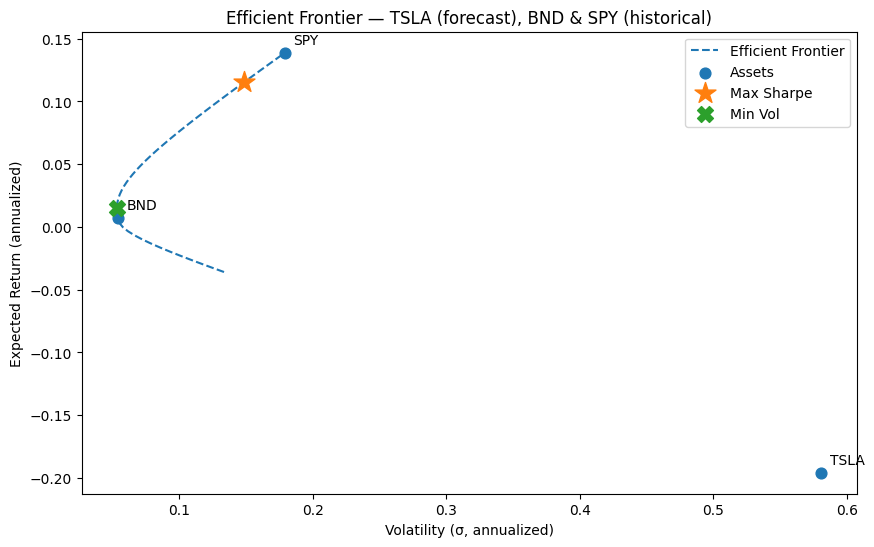

In [10]:
plt.figure(figsize=(10,6))
plt.plot(sigmas, mus, '--', label='Efficient Frontier')

# individual assets
asset_sigmas = np.sqrt(np.diag(Sigma_M))
plt.scatter(asset_sigmas, mu_vec, s=60, label='Assets')
for i,t in enumerate(tickers):
    plt.annotate(t, (asset_sigmas[i], mu_vec[i]), xytext=(6,6), textcoords='offset points')

# key portfolios
plt.scatter([vol_ms], [mu_ms], marker='*', s=250, label='Max Sharpe', zorder=3)
plt.scatter([vol_mv], [mu_mv], marker='X', s=130, label='Min Vol', zorder=3)

plt.xlabel("Volatility (σ, annualized)")
plt.ylabel("Expected Return (annualized)")
plt.title("Efficient Frontier — TSLA (forecast), BND & SPY (historical)")
plt.legend()
plt.show()


# Printed summary

In [11]:
# Simple rule: if Sharpe(MaxSharpe) exceeds MinVol by >= 0.10 → pick MaxSharpe; else MinVol for stability
pick = "MaxSharpe" if summary.loc["MaxSharpe","sharpe"] >= summary.loc["MinVol","sharpe"] + 0.10 else "MinVol"
weights = weights_ms if pick=="MaxSharpe" else weights_mv
mu_p, vol_p, sh_p = (summary.loc[pick, "exp_return"], summary.loc[pick, "volatility"], summary.loc[pick, "sharpe"])

print("=== Recommended Portfolio ===")
print(f"Choice: {pick}  (rf={RF:.2%})")
print("\nWeights")
print(weights.apply(lambda x: round(x,4)))
print("\nPerformance (annualized)")
print(f"Expected return: {mu_p:.4f}")
print(f"Volatility     : {vol_p:.4f}")
print(f"Sharpe         : {sh_p:.4f}")

=== Recommended Portfolio ===
Choice: MaxSharpe  (rf=0.00%)

Weights
TSLA   0.000000
BND    0.179900
SPY    0.820100
Name: MaxSharpe, dtype: float64

Performance (annualized)
Expected return: 0.1152
Volatility     : 0.1482
Sharpe         : 0.7773
